# Clustering Application
## Student: Marcos Gil

First we load a few libraries. csv is used to load the dataset.

In [2]:
import numpy as np
import csv
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

#Some code to set the colors and the legends for the plots:
cmap = ListedColormap(['cyan', 'crimson'])

def translate(val):
    if val == 1:
        return 'Pulsar'
    else:
        return 'Noise'

legend_handles = []
for category in set([0,1]):
    label = translate(category)
    color = cmap(category)
    legend_handles.append(mpatches.Patch(color=color, label=label))

The dataset is a series of 8 measurements related to pulsars (columns 0,...,7). The last column says if the object is a pulsar (1), or not (0). It contains 16,259 spurious examples caused by noise, and 1,639	real pulsars. We note that it is a pretty unbalanced dataset. More details can be found in the `Readme.txt` of the `htru2` folder.

In [3]:
#Opens the data
with open('htru2/HTRU_2.csv', 'r') as f:
    reader = csv.reader(f)
    _data = list(reader)

#Converts it to a numpy array
data = np.array(_data, dtype=np.float32)
x = data[:,0:7] #Measurements
y = data[:,8] #Label

We start with a PCA with three components:

In [4]:
pca = PCA(n_components=3) #Starting the PCA
pca.fit(x); #Fitting the measurements

Let us see how much of the variance each component captures:

In [19]:
print(pca.explained_variance_ratio_)
print("Normalized Variance: %1.3f" % sum(pca.explained_variance_ratio_)) #More than 97% of the variance. Great!

[0.64110005 0.27904403 0.05398659]
Normalized Variance: 0.974


Let us then use the PCA to reduce the dimensionality of our data:

In [6]:
reduced_x = pca.fit_transform(x)

Now some visualizations. Here, we make a scatter plot in 2D. The third dimension is represented by the color.

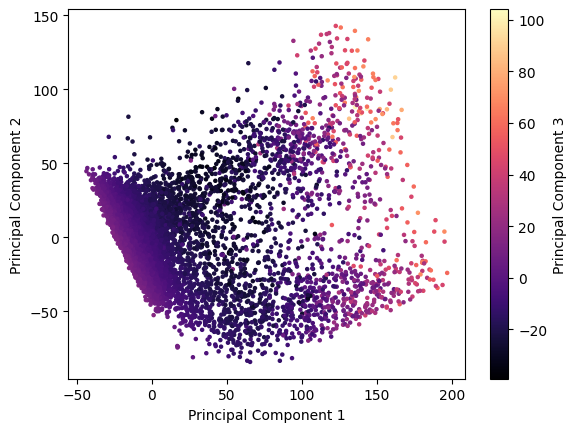

In [7]:
sc = plt.scatter(reduced_x[:,0],reduced_x[:,1],c=reduced_x[:,2],s=5,cmap='magma')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(sc, label = 'Principal Component 3');

Now we discard the third dimension and use the color to see if the object is a pulsar or not. There is a nice spatial separation, where the pulsars appear concentrated in the lower branch.

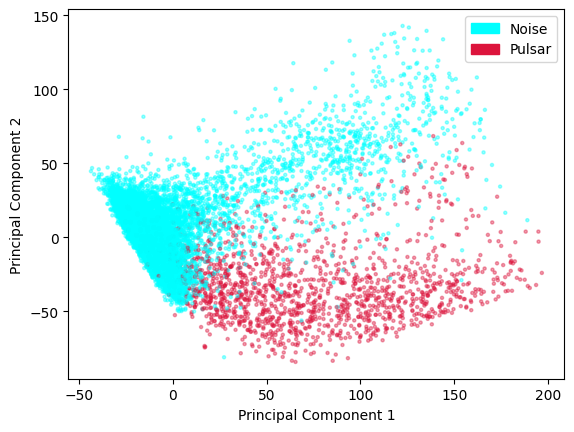

In [8]:
sc = plt.scatter(reduced_x[:,0],reduced_x[:,1],c=y,s=5,alpha=0.4,cmap=cmap)
plt.legend(handles=legend_handles)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2');

Now let us perform the clustering. We would hope that with only two clusters we would get a good classification between pulsar and noise, but that is not the case. In the cell below, one may change the number of clusters and visualize them in two dimensions. 

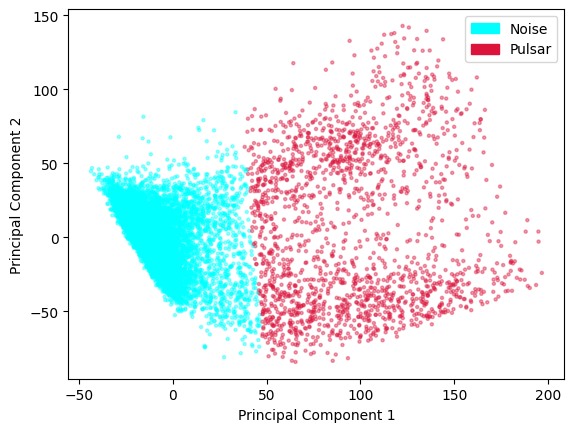

In [9]:
kmeans = KMeans(n_clusters=2, n_init=10)
y_kmeans = kmeans.fit_predict(reduced_x)
sc = plt.scatter(reduced_x[:,0],reduced_x[:,1],c=y_kmeans,s=5,alpha=0.4,cmap=cmap)
plt.legend(handles=legend_handles)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2');

Let us try the following strategy to perform the classification: we will try different numbers of clusters, and classify one cluster as the pulsar case, while all the others will be noise. This "binaryzation" is achieved by the following function:

In [10]:
def _make_binary(y,cluster):
    if y == cluster:
        return 1
    else:
        return 0

make_binary = np.vectorize(_make_binary)

In order to select the best number of clusters, we have to introduce some sort of metric. But we have to be careful, because of the unbalance in the dataset. If we looked only at the classification accuracy, a strategy of classifying all points as noise would give us an accuracy of over 90%, which is very misleading. For that reason, we will look to the number of **true positive** classifications, that is, the number of points that are pulsars and are classified as pulsars. The `format` function will then return a formatted version of the output of the `KMeans` algorithm, which classifies the best cluster (the one that maximizes the number of true positives) as pulsars, while everything else is classified as noise.

In [11]:
def _true_positives(y1,y2):
    if y1 == 1 and y2 == 1:
        return 1
    else:
        return 0

def true_positives(y1,y2):
    return np.vectorize(_true_positives)(y1,y2).sum()

def format(y,y_kmeans,n_clusters):
    corrects = np.zeros(n_clusters)

    for cluster in range(n_clusters):
        fy_kmeans = make_binary(y_kmeans,cluster)
        corrects[cluster] = true_positives(y,fy_kmeans)
    
    cluster = np.argmax(corrects,axis=0)
    return make_binary(y_kmeans,cluster)

We note also that the spurious strategy of classifying all points as pulsars would maximize the number of true positives, which would also be misleading. Therefore, we will calculate the number of **false positives** as well.

In [12]:
def _false_positives(y1,y2):
    if y1 == 0 and y2 == 1:
        return 1
    else:
        return 0

def false_positives(y1,y2):
    return np.vectorize(_false_positives)(y1,y2).sum()

Now everything is in place! We vary the number of clusters, format them according to our strategy, and finally calculate the number of true and false positives, which are normalized by the number of pulsars.

In [13]:
max = 10
tps = np.zeros(max - 2)
fps = np.zeros(max - 2)
N = sum(y == 1)

for n in range(2,max):
    kmeans = KMeans(n, n_init=10)
    y_kmeans = kmeans.fit_predict(reduced_x)
    fy_kmeans = format(y,y_kmeans,n)
    tps[n-2] = true_positives(y,fy_kmeans) / N
    fps[n-2] = false_positives(y,fy_kmeans) / N

Now we make histograms:

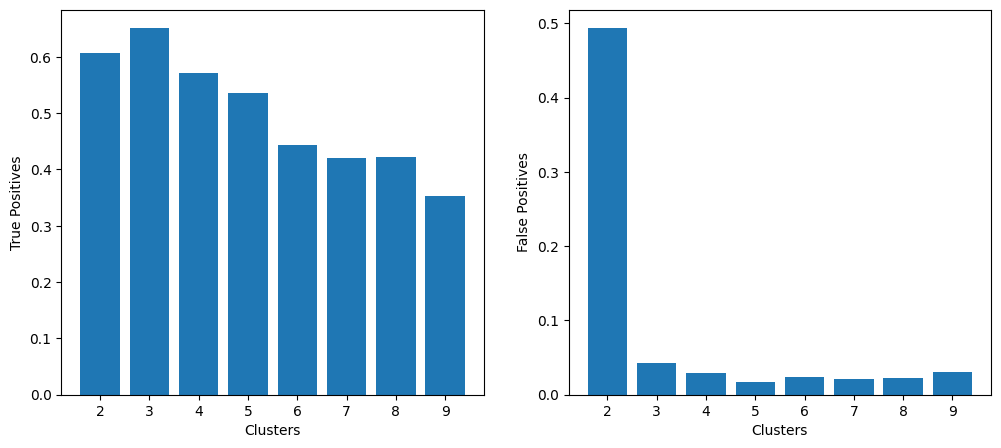

In [14]:
fig = plt.figure(figsize=(12,5))
ax1, ax2 = fig.subplots(1, 2)

ax1.bar(range(2,max), tps)
ax1.set_xlabel('Clusters')
ax1.set_ylabel('True Positives')

ax2.bar(range(2,max), fps)
ax2.set_xlabel('Clusters')
ax2.set_ylabel('False Positives');

We see that a number of 3 clusters achieves a good balance between the number of true and false positives:

In [15]:
print("True Positives with 3 clusters: %1.2f" % tps[1])
print("False Positives with 3 clusters: %1.2f" % fps[1])

True Positives with 3 clusters: 0.65
False Positives with 3 clusters: 0.04


Let us see how it divides the data:

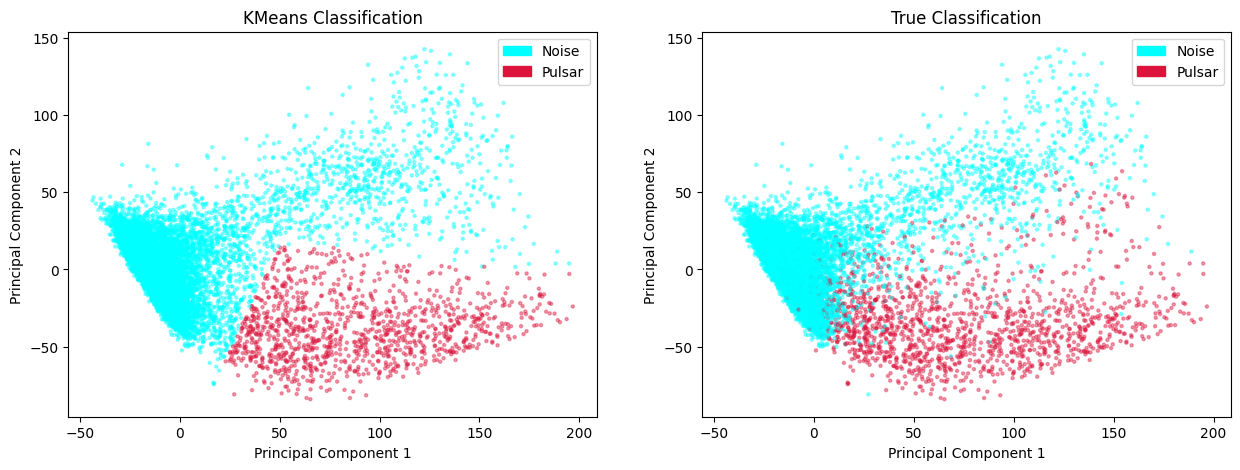

In [16]:
kmeans = KMeans(3, n_init=10)
y_kmeans = kmeans.fit_predict(reduced_x)
fy_kmeans = format(y,y_kmeans,3)

fig = plt.figure(figsize=(15,5))
ax1, ax2 = fig.subplots(1, 2)

sc1 = ax1.scatter(reduced_x[:,0],reduced_x[:,1],c=fy_kmeans,s=5,alpha=0.4,cmap=cmap)
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')
ax1.set_title("KMeans Classification")

sc2 = ax2.scatter(reduced_x[:,0],reduced_x[:,1],c=y,s=5,alpha=0.4,cmap=cmap)
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')
ax2.set_title("True Classification")

ax1.legend(handles=legend_handles)
ax2.legend(handles=legend_handles);

The clustering algorithm appears to do a reasonable job in the classification. The issue appears to be that it draws sharp borders between the regions corresponding to noise and pulsars, while, in reality, the boundary appears more diffuse. We can also see that the PCA indeed picked up the most important features of our problem, because if we change `x_reduced` to `x` in the cell above, there cannot be seen any perceptible changes in the classification.